## Import packages

In [1]:
# Enable auto reloading modules (used because of custom local modules)
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pickle
import os
import glob

# Custom local modules
import utils
import ImageFunctions as imgf
import LaneDetector as ld

%matplotlib inline

## Directories and constants

In [3]:
output_images_dir = os.path.join('..', 'output_images')
test_images_dir = os.path.join('..', 'test_images')

cal_data_file = 'calibration.pickle' # file where to save the distortion coefficients

## Camera distortion

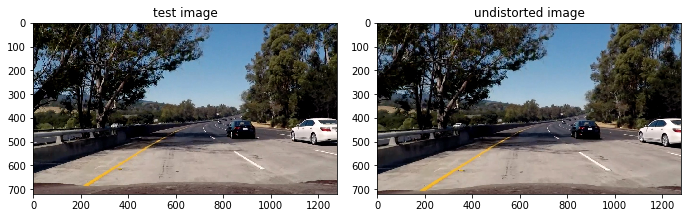

In [4]:
test_image = mpimg.imread(os.path.join(test_images_dir, 'test5.jpg'))

undistorted_image = imgf.undistort(test_image, cal_data_file)

fig = utils.plot_images_as_grid([test_image, undistorted_image], ['test image', 'undistorted image'], figsize=(24, 8))

## View color spaces

In [5]:
# Display color channels of undistorted image in different color spaces 
utils.plot_color_channels(undistorted_image, labels=['R','G','B'])

hsv_image = imgf.to_hsv(undistorted_image)
utils.plot_color_channels(hsv_image, labels=['H','S','V'])

hls_image = imgf.to_hls(undistorted_image)
fig = utils.plot_color_channels(hls_image, labels=['H','L','S'])

## Apply color thresholds

There are many tools out there to take advantage of HLS color space by helping to find the hue range of specific colors (e.g. https://www.w3schools.com/colors/colors_hsl.asp). For yellow colors the hue angle is approximately between 40° and 70°. However, OpenCV only has a circle up to 180° to fit it in 8 bits (0-255). So, values get divided by 2 which makes a range of 20° to 35° for yellow. I try to use it to apply an appropriate threshold for the H-channel to detect yellow lines. However, the optimized results are not better than the ones from the S-channel which leads me to only using the S-channel to detect them.

For picking up the white lines, the R-channel might be considerable, but as I only want to get white lines more confident than through the S-channel, it shows that a thresholded grayscale image might be preferable because we get less noise and other pixels than white ones.

In [6]:
# Applying color thresholds
s_threshold = imgf.color_threshold(hls_image, 2, (170, 255))
h_threshold = imgf.color_threshold(hls_image, 0, (20, 40))
r_threshold = imgf.color_threshold(undistorted_image, 0, (200, 255))

gray_image = imgf.to_grayscale(undistorted_image)
gray_threshold = imgf.color_threshold((np.dstack((gray_image, gray_image, gray_image))), 0, (200, 255))

threshold_images = [s_threshold, h_threshold, r_threshold, gray_threshold]
threshold_labels = ['S threshold', 'H threshold', 'R threshold', 'gray threshold']
fig = utils.plot_images_as_grid(threshold_images, threshold_labels, images_per_row=4, figsize=(20, 4), cmap='gray')

Now I will combine the S-channel with the gray thresholds:

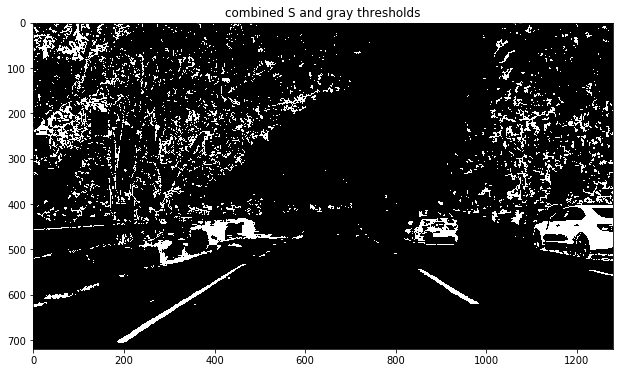

In [7]:
combined_color_thresholds = imgf.combine_binary(s_threshold, gray_threshold)

plt.figure(figsize=(16, 6))
ax = plt.gca()
ax.set_title('combined S and gray thresholds')
plt.imshow(combined_color_thresholds, cmap='gray')

## Adding gradient thresholds

As the color thresholds especially show a lack of lines in the distance because the color values lose intensity, gradient thresholds will be added with the Sobel-operator to overcome these shortcomings.

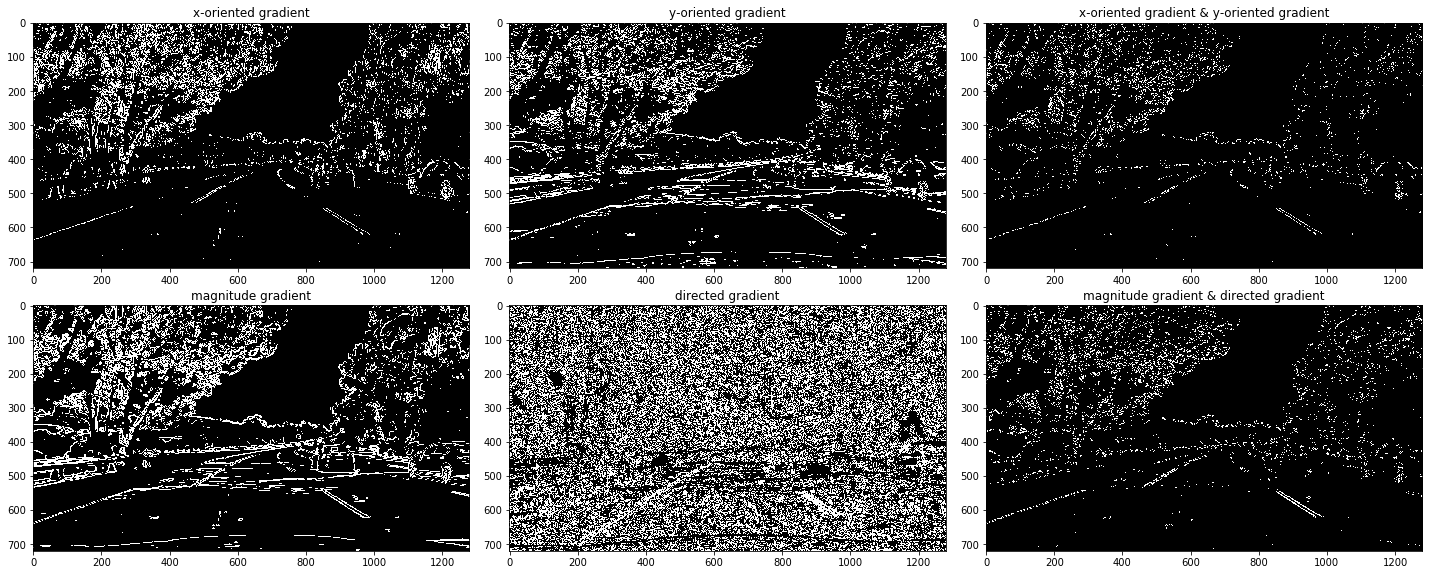

In [8]:
sobel = imgf.SobelGradientThresholder(undistorted_image, sobel_kernel=3)
x_gradient = sobel.abs_thresh(orient='x', thresh=(20, 100))
y_gradient = sobel.abs_thresh(orient='y', thresh=(20, 100))
x_y_gradient = np.zeros_like(x_gradient)
x_y_gradient[((x_gradient == 1) & (y_gradient == 1))] = 1

sobel_large = imgf.SobelGradientThresholder(undistorted_image, sobel_kernel=7)
mag_gradient = sobel_large.mag_thresh(thresh=(30, 100))
dir_gradient = sobel_large.dir_thresh(thresh=(0.6, 1.3))
mag_dir_gradient = np.zeros_like(mag_gradient)
mag_dir_gradient[((mag_gradient == 1) & (dir_gradient == 1))] = 1

gradient_images = [x_gradient, y_gradient, x_y_gradient, mag_gradient, dir_gradient, mag_dir_gradient]
labels = ['x-oriented gradient', 'y-oriented gradient', 'x-oriented gradient & y-oriented gradient', 
          'magnitude gradient', 'directed gradient', 'magnitude gradient & directed gradient']
fig = utils.plot_images_as_grid(gradient_images, labels, images_per_row=3, figsize=(20, 8), cmap='gray')

I decided to only use the `x_gradient` as the other combinations either add too much noise or lack pixel density in the distance.

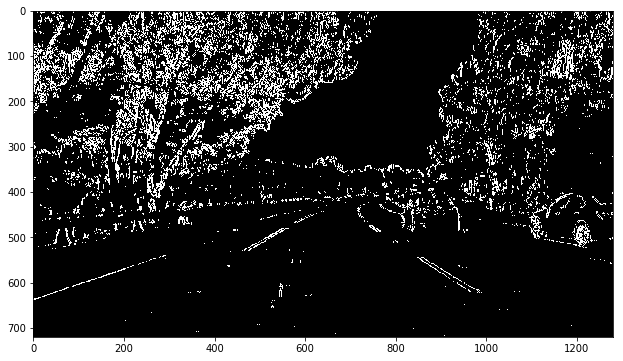

In [9]:
gradient_thresholds = x_gradient

plt.figure(figsize=(16, 6))
plt.imshow(gradient_thresholds, cmap='gray')

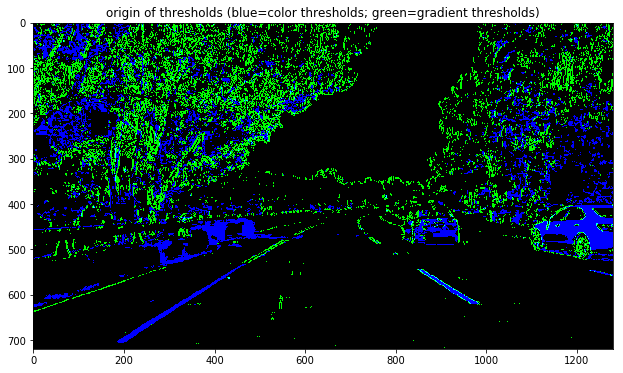

In [10]:
color_binary = np.dstack(( np.zeros_like(gradient_thresholds), gradient_thresholds, combined_color_thresholds)) * 255
plt.figure(figsize=(16, 6))
plt.imshow(color_binary)
plt.gca().set_title('origin of thresholds (blue=color thresholds; green=gradient thresholds)')
plt.savefig(os.path.join(output_images_dir, 'colored_thresholds.jpg'), bbox_inches='tight')

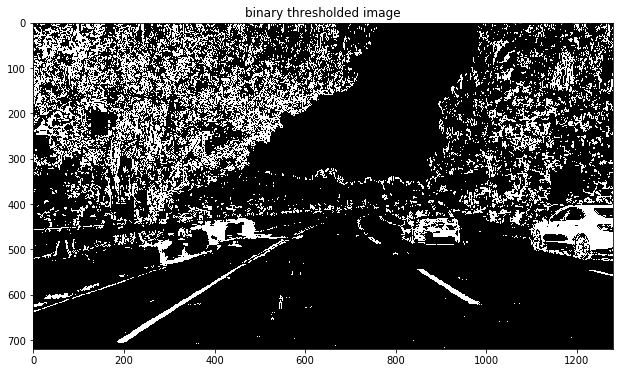

In [11]:
# Create a binary image with gradient and color thresholds together like the colored one above
thresholded_image = imgf.combine_binary(gradient_thresholds, combined_color_thresholds)

plt.figure(figsize=(16, 6))
plt.imshow(thresholded_image, cmap='gray')
plt.gca().set_title('binary thresholded image')
plt.savefig(os.path.join(output_images_dir, 'thresholded_image.jpg'), bbox_inches='tight')

## Perspective transform

Tuning the source and destination coordinates of our perspective transform is done by observing the images with straight road lines.

For the destination points, I chose y-values equal to the top and bottom of the original images and x-values to be at
1/4 and 3/4 of the width because lanes would optimally be centered in the left and right halves.

undistorted image size: (1280, 720)
source coordinates:
[[ 593.15594  450.     ]
 [ 690.84406  450.     ]
 [1120.       720.     ]
 [ 210.       720.     ]]
destination coordinates:
[[320.   0.]
 [960.   0.]
 [960. 720.]
 [320. 720.]]


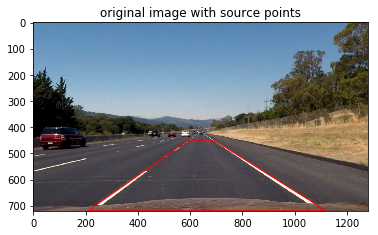

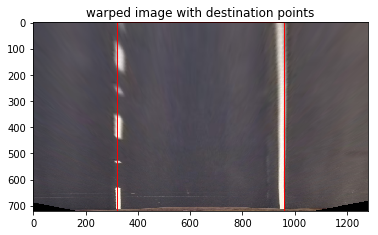

In [12]:
straight_image = mpimg.imread(os.path.join(test_images_dir, 'straight_lines2.jpg'))
undistorted_straight_image = imgf.undistort(straight_image, cal_data_file)

image_size = undistorted_straight_image.shape[1], undistorted_straight_image.shape[0]
print(f'undistorted image size: {image_size}')

top_y = image_size[1]/1.6
bottom_y = image_size[1]

bottom_x_margin = image_size[0]/8
bottom_left_x = 50+bottom_x_margin
bottom_right_x = image_size[0]-bottom_x_margin

top_x_margin = image_size[0]/2.18
top_left_x = top_x_margin+6
top_right_x = image_size[0]-top_x_margin-2

# Having the lines one fourth away from left and right corner of the transformed image seems optimal
# because that way the lanes are centered in the left and right half at the bottom of the image.
dst_left_x = image_size[0]/4
dst_right_x = dst_left_x*3

trans_src = np.float32([
    [top_left_x, top_y],        # top-left
    [top_right_x, top_y],       # top-right
    [bottom_right_x, bottom_y], # bottom-right
    [bottom_left_x, bottom_y],  # bottom-left
])
trans_dst = np.float32([
    [dst_left_x, 0],              # top-left
    [dst_right_x, 0],             # top-right
    [dst_right_x, image_size[1]], # bottom-right
    [dst_left_x, image_size[1]]   # bottom-left
])
trans_straight_image = imgf.transform_perspective(undistorted_straight_image, trans_src, trans_dst)

plt.gca().set_title('original image with source points')
plt.imshow(undistorted_straight_image)
plt.fill(trans_src[:,0], trans_src[:,1]-.5, edgecolor='r', fill=False)
plt.savefig(os.path.join(output_images_dir, 'transform_unwarped.jpg'), bbox_inches='tight')

plt.figure()
plt.gca().set_title('warped image with destination points')
plt.imshow(trans_straight_image)
plt.fill(trans_dst[:,0], trans_dst[:,1]-.5, edgecolor='r', fill=False)
plt.savefig(os.path.join(output_images_dir, 'transform_warped.jpg'), bbox_inches='tight')

print('source coordinates:')
print(trans_src)
print('destination coordinates:')
print(trans_dst)

Applying the same transformation on our thresholded binary image yields the following result:

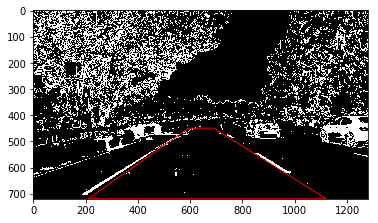

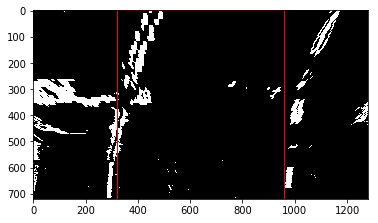

In [13]:
plt.imshow(thresholded_image, cmap='gray')
plt.fill(trans_src[:,0], trans_src[:,1]-.5, edgecolor='r', fill=False)

plt.figure()
trans_image = imgf.transform_perspective(thresholded_image, trans_src, trans_dst)
plt.imshow(trans_image, cmap='gray')
plt.fill(trans_dst[:,0], trans_dst[:,1]-.5, edgecolor='r', fill=False)

## Finding the lane lines

Lane lines of a single image are identified through executing a sliding window search starting from the peaks of a histogram. Then the identified pixels will be averaged to fit them to a second order polynomial function.

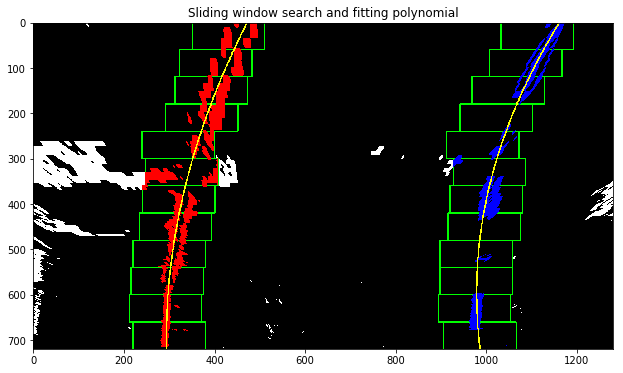

In [14]:
plt.figure(figsize=(14, 6))

lane_det = ld.LaneDetector(n_windows=12, margin=80, min_pix=60) 
lane_det.run_on_image(trans_image)

visualization = lane_det.get_visualization()
plt.gca().set_title('Sliding window search and fitting polynomial')
plt.imshow(visualization)
plt.savefig(os.path.join(output_images_dir, 'lane_fitting.jpg'), bbox_inches='tight')

## Plotting the result

In [15]:
lane_area = lane_det.render_lane_area()
colored_lanes = lane_det.render_lanes()

# Warp the blank back to original image space using inverse perspective matrix (Minv)
lane_area_unwarped = imgf.transform_perspective(lane_area, trans_dst, trans_src)
lanes_unwarped = imgf.transform_perspective(colored_lanes, trans_dst, trans_src)

# Combine the result with the original image
result = cv2.addWeighted(undistorted_image, 1., lane_area_unwarped, .3, 1)
lane_det.display_metrics(result)
plt.figure(figsize=(14, 6))
plt.imshow(imgf.image_overlay(lanes_unwarped, result, overlay_transparency=.1))
plt.savefig(os.path.join(output_images_dir, 'result.jpg'), bbox_inches='tight')